In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset import get_rays
from rendering import rendering
from rendering import *

import torch
import torch.nn as nn

batch_size = 1024
o,d,target_px_values = get_rays("fox", mode='train')
dataloader = DataLoader(torch.cat((
    torch.from_numpy(o),
    torch.from_numpy(d),
    torch.from_numpy(target_px_values)), dim=1), 
    batch_size = batch_size, shuffle=True)

test_o, test_d, test_target_px_values = get_rays('fox', mode='test')


/Users/gimchangheon/opt/anaconda3/envs/dl-challenge/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:

class Voxels(nn.Module):
    
    def __init__(self, nb_voxels=100, scale=1, device='cpu'):
        super(Voxels, self).__init__()
        
        self.voxels = torch.nn.Parameter(torch.rand((nb_voxels, nb_voxels, nb_voxels, 4), 
                                                    device=device, requires_grad=True))
        
        self.nb_voxels = nb_voxels
        self.device = device
        self.scale = scale
        
    def forward(self, xyz, d):
        
        x = xyz[:, 0]
        y = xyz[:, 1]
        z = xyz[:, 2]
        
        cond = (x.abs() < (self.scale / 2)) & (y.abs() < (self.scale / 2)) & (z.abs() < (self.scale / 2))
        colors_and_densities = torch.zeros((xyz.shape[0], 4), device=xyz.device)
        colors_and_densities[cond, :3] = torch.tensor([1.,0,0])
        colors_and_densities[cond, -1] = 10
         
        return (colors_and_densities[:, :3]), (colors_and_densities[:, -1:])
        # return torch.sigmoid(colors_and_densities[:, :3]), torch.relu(colors_and_densities[:, -1:])
        
    
    def intersect(self, x, d):
        return self.forward(x, d)


In [12]:
print(o[-1].shape)

(160000, 3)


In [10]:
model = Voxels(scale=1)
img = rendering(model, torch.from_numpy(o[-1]), torch.from_numpy(d[-1]), 8, 12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


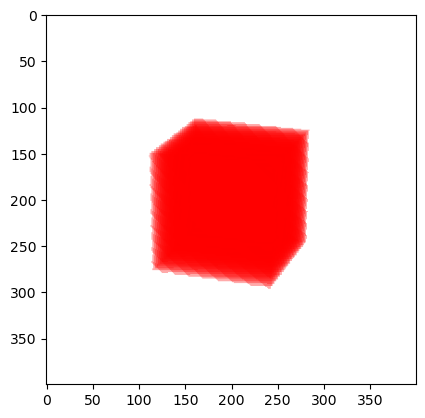

In [11]:
plt.imshow(img.reshape(400,400,3).data.cpu().numpy())

In [13]:

class Voxels(nn.Module):
    
    def __init__(self, nb_voxels=100, scale=1, device='cpu'):
        super(Voxels, self).__init__()
        
        self.voxels = torch.nn.Parameter(torch.rand((nb_voxels, nb_voxels, nb_voxels, 4), 
                                                    device=device, requires_grad=True))
        
        self.nb_voxels = nb_voxels
        self.device = device
        self.scale = scale
        
    def forward(self, xyz, d):
        
        x = xyz[:, 0]
        y = xyz[:, 1]
        z = xyz[:, 2]
        
        cond = (x.abs() < (self.scale / 2)) & (y.abs() < (self.scale / 2)) & (z.abs() < (self.scale / 2))
        
        indx = (x[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(torch.long)
        indy = (y[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(torch.long)
        indz = (z[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(torch.long)
        
        colors_and_densities = torch.zeros((xyz.shape[0], 4), device=xyz.device)
        colors_and_densities[cond, :3] = self.voxels[indx, indy, indz, :3]
        colors_and_densities[cond, -1] = self.voxels[indx, indy, indz, -1]
         
        # return (colors_and_densities[:, :3]), (colors_and_densities[:, -1:])
        return torch.sigmoid(colors_and_densities[:, :3]), torch.relu(colors_and_densities[:, -1:])
        
    
    def intersect(self, x, d):
        return self.forward(x, d)


In [14]:
model = Voxels(scale=1)
img = rendering(model, torch.from_numpy(o[-1]), torch.from_numpy(d[-1]), 8, 12)

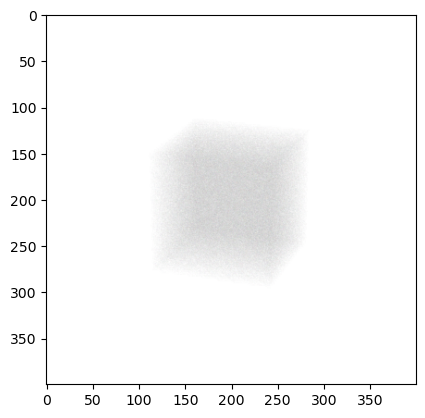

In [15]:
plt.imshow(img.reshape(400,400,3).data.cpu().numpy())
